In [1]:
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c districtdatalabs yellowbrick --yes
#!pip install transliterate==1.10.2

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 300)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#import sys, json, os, 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
# Distortion Score Elbow for k-means clustering
from yellowbrick.cluster import KElbowVisualizer 

%matplotlib inline
from matplotlib import pyplot as plt

import folium # map rendering library

print('Libraries imported.')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported.


In [2]:
df_minsk = pd.read_excel('Minsk.xlsx')
df_minsk.head()

,Borough,Neighborhood,Full address
0,Фрунзенский,Сухарево,"Минск, Фрунзенский район, Сухарево"
1,Фрунзенский,Запад,"Минск, Фрунзенский район, Запад"
2,Фрунзенский,Красный Бор,"Минск, Фрунзенский район, Красный Бор"
3,Фрунзенский,Медвежино,"Минск, Фрунзенский район, Медвежино"
4,Фрунзенский,Кунцевщина,"Минск, Фрунзенский район, Кунцевщина"


In [3]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_minsk['Borough'].unique()),
        df_minsk.shape[0]
    )
)

The dataframe has 9 boroughs and 64 neighborhoods.


In [4]:
df_minsk['Latitude'] = ''
df_minsk['Longitude'] = ''

for index, row in df_minsk.iterrows():
    address = df_minsk['Full address'][index]
    geolocator = Nominatim(user_agent="minsk")
    location = geolocator.geocode(address)
    try:
        df_minsk['Latitude'][index] = location.latitude
        df_minsk['Longitude'][index] = location.longitude
    except AttributeError:
        print("For neighborhood "+df_minsk['Full address'][index]+" cannot find coordinates")

In [5]:
# drop Full address column
df_minsk.drop(['Full address'], axis='columns', inplace=True)
df_minsk.head()

,Borough,Neighborhood,Latitude,Longitude
0,Фрунзенский,Сухарево,53.8867,27.4271
1,Фрунзенский,Запад,53.8993,27.4503
2,Фрунзенский,Красный Бор,53.902,27.4245
3,Фрунзенский,Медвежино,53.8955,27.4689
4,Фрунзенский,Кунцевщина,53.9114,27.4441


In [6]:
# translitarate from russian
from transliterate import translit, get_available_language_codes

for index, row in df_minsk.iterrows():
    text1 = df_minsk['Borough'][index]
    df_minsk['Borough'][index] = translit(text1, 'ru', reversed=True)
    text2 = df_minsk['Neighborhood'][index]
    df_minsk['Neighborhood'][index] = translit(text2, 'ru', reversed=True)

In [7]:
df_minsk.head()

,Borough,Neighborhood,Latitude,Longitude
0,Frunzenskij,Suharevo,53.8867,27.4271
1,Frunzenskij,Zapad,53.8993,27.4503
2,Frunzenskij,Krasnyj Bor,53.902,27.4245
3,Frunzenskij,Medvezhino,53.8955,27.4689
4,Frunzenskij,Kuntsevschina,53.9114,27.4441


In [8]:
address = 'Minsk, Belarus'

geolocator = Nominatim(user_agent="belarus")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Minsk City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Minsk City are 53.902334, 27.5618791.


In [9]:
# create map of Minsk using latitude and longitude values
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_minsk['Latitude'], df_minsk['Longitude'], df_minsk['Borough'], df_minsk['Neighborhood']):
    label = '{} Borough, Neighborhood - {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minsk)  
    
map_minsk

In [10]:
CLIENT_ID = 'HFYZXZNQ52NTLRBDURWUSJOFW1DPKSTXAKHFBGKJJC5KIS25'
CLIENT_SECRET = 'IHQBRLCOD1ICQH4TMGRHWA5RK53SOLL0NTU1XZIHOZCU5F4H'
VERSION = '20180605'
LIMIT = 100

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
minsk_venues = getNearbyVenues(names=df_minsk['Neighborhood'], latitudes=df_minsk['Latitude'], longitudes=df_minsk['Longitude'])

Suharevo
Zapad
Krasnyj Bor
Medvezhino
Kuntsevschina
Kamennaja Gorka
Dombrovka
Masjukovschina
Rakovskoe shosse
Promuzel Zapadnyj
Kaskad
Tivali
Har'kovskaja
Degtjarevka
Grushevka
Mihalovo
Petrovschina
Malinovka
Brilevichi
Semashko
Filial BGU
Jugo-Zapad
Kurasovschina
Aerodromnaja
Koljadichi
Minsk-Siti
Serova
Chizhovka
Shabany
Angarskaja
Severnyj poselok
Malyj Trostenets
Sosny
Slepjanka
Stepjanka
Drazhnja
Pulihova
Sokol
Rzhavets
Novinki
Vesnjanka
Verhnij gorod
Zhdanovichi
Zaslavskaja
Zatsen'
Lebjazhij
poselok Raduzhnyj
Storozhovka
Troitskoe predmest'e
Tsnjanka
Zelenyj lug
Komarovka
Sel'hozposelok
Tsna
Borovljany
Loshitsa
Serebrjanka
Uruch'e
Vostok
Ozerische
Vostochnyj
Akademgorodok
Akademija nauk
Novaja Borovaja


In [14]:
print(minsk_venues.shape)
minsk_venues.head()

(1030, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Suharevo,53.88665,27.427141,фитнес-клуб «Старт+»,53.889615,27.428852,Gym / Fitness Center
1,Suharevo,53.88665,27.427141,"Салон красоты ""Карамель""",53.886722,27.430281,Yoga Studio
2,Suharevo,53.88665,27.427141,Банно-оздоровительный комплекс «Сухарево»,53.887432,27.422580,Bath House
3,Suharevo,53.88665,27.427141,Мила,53.888478,27.422119,Cosmetics Shop
4,Suharevo,53.88665,27.427141,Точка на Сухаревской,53.888686,27.422195,Beer Store


In [15]:
print(minsk_venues['Venue Category'].value_counts()[0:20])

Bus Stop                84
Café                    35
Coffee Shop             34
Gym / Fitness Center    29
Pizza Place             26
Food & Drink Shop       26
Gym                     25
Park                    24
Restaurant              23
Cosmetics Shop          23
Cocktail Bar            21
Hotel                   18
Pharmacy                17
Bar                     16
Soccer Field            15
Grocery Store           13
Spa                     12
Flower Shop             12
Electronics Store       12
Fast Food Restaurant    11
Name: Venue Category, dtype: int64


In [16]:
# Gyms, pools, yoga
minsk_gyms = minsk_venues.drop(np.where((minsk_venues['Venue Category'] != 'Gym') & 
                                        (minsk_venues['Venue Category'] != 'Gym / Fitness Center') & 
                                        (minsk_venues['Venue Category'] != 'Gym Pool') & 
                                        (minsk_venues['Venue Category'] != 'Gymnastics Gym') &
                                        (minsk_venues['Venue Category'] != 'Pool') &
                                        (minsk_venues['Venue Category'] != 'Sports Club') &
                                        (minsk_venues['Venue Category'] != 'Yoga Studio') &
                                        (minsk_venues['Venue Category'] != 'Athletics & Sports')
                                       )[0])

In [17]:
print(minsk_gyms.shape)
minsk_gyms.head()

(75, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Suharevo,53.886650,27.427141,фитнес-клуб «Старт+»,53.889615,27.428852,Gym / Fitness Center
1,Suharevo,53.886650,27.427141,"Салон красоты ""Карамель""",53.886722,27.430281,Yoga Studio
11,Zapad,53.899276,27.450313,Фрунзенский физкультурно-оздоровительный центр,53.894694,27.451526,Gym / Fitness Center
12,Zapad,53.899276,27.450313,Фрунзенский ФОЦ,53.902711,27.449563,Gym / Fitness Center
35,Kuntsevschina,53.911438,27.444141,Тонус,53.910778,27.448675,Gym


In [18]:
print(minsk_gyms['Venue Category'].value_counts()[0:20])

Gym / Fitness Center    29
Gym                     25
Athletics & Sports       8
Gym Pool                 4
Pool                     3
Yoga Studio              3
Gymnastics Gym           2
Sports Club              1
Name: Venue Category, dtype: int64


In [19]:
minsk_gyms.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akademgorodok,3,3,3,3,3,3
Akademija nauk,2,2,2,2,2,2
Angarskaja,4,4,4,4,4,4
Borovljany,1,1,1,1,1,1
Brilevichi,1,1,1,1,1,1
Chizhovka,1,1,1,1,1,1
Dombrovka,1,1,1,1,1,1
Filial BGU,2,2,2,2,2,2
Grushevka,2,2,2,2,2,2


In [20]:
# one hot encoding
minsk_onehot = pd.get_dummies(minsk_gyms[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
minsk_onehot['Neighborhood'] = minsk_gyms['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [minsk_onehot.columns[-1]] + list(minsk_onehot.columns[:-1])
minsk_onehot = minsk_onehot[fixed_columns]

minsk_onehot.head()

,Neighborhood,Athletics & Sports,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Pool,Sports Club,Yoga Studio
0,Suharevo,0,0,1,0,0,0,0,0
1,Suharevo,0,0,0,0,0,0,0,1
11,Zapad,0,0,1,0,0,0,0,0
12,Zapad,0,0,1,0,0,0,0,0
35,Kuntsevschina,0,1,0,0,0,0,0,0


In [21]:
minsk_onehot.shape

(75, 9)

In [22]:
minsk_grouped = minsk_onehot.groupby('Neighborhood').mean().reset_index()
minsk_grouped.head()

,Neighborhood,Athletics & Sports,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Pool,Sports Club,Yoga Studio
0,Akademgorodok,0.333333,0.0,0.333333,0.0,0.333333,0.00,0.0,0.0
1,Akademija nauk,0.000000,0.5,0.000000,0.5,0.000000,0.00,0.0,0.0
2,Angarskaja,0.000000,0.0,0.750000,0.0,0.000000,0.25,0.0,0.0
3,Borovljany,1.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0
4,Brilevichi,0.000000,0.0,0.000000,0.0,0.000000,1.00,0.0,0.0


In [23]:
minsk_grouped.shape

(34, 9)

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = minsk_grouped['Neighborhood']

for ind in np.arange(minsk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minsk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Akademgorodok,Gymnastics Gym,Gym / Fitness Center,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gym Pool
1,Akademija nauk,Gym Pool,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym / Fitness Center
2,Angarskaja,Gym / Fitness Center,Pool,Yoga Studio,Sports Club,Gymnastics Gym,Gym Pool,Gym
3,Borovljany,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
4,Brilevichi,Pool,Yoga Studio,Sports Club,Gymnastics Gym,Gym Pool,Gym / Fitness Center,Gym


In [26]:
minsk_grouped_clustering = minsk_grouped.drop('Neighborhood', 1)
minsk_grouped_clustering.head()

,Athletics & Sports,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Pool,Sports Club,Yoga Studio
0,0.333333,0.0,0.333333,0.0,0.333333,0.00,0.0,0.0
1,0.000000,0.5,0.000000,0.5,0.000000,0.00,0.0,0.0
2,0.000000,0.0,0.750000,0.0,0.000000,0.25,0.0,0.0
3,1.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.000000,1.00,0.0,0.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


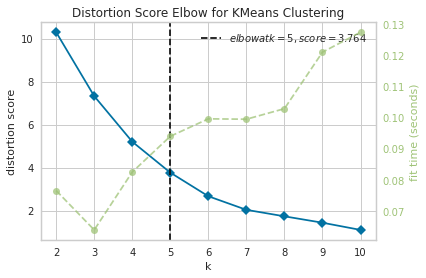

In [27]:
model = KElbowVisualizer(KMeans(), k=10)
model.fit(minsk_grouped_clustering)
model.show()

In [28]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(minsk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 2, 1, 4, 2, 2, 3, 3, 0], dtype=int32)

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

minsk_merged = df_minsk

# merge minsk_grouped with minsk_data to add latitude/longitude for each neighborhood
minsk_merged = minsk_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [30]:
minsk_merged.dropna(subset=['Cluster Labels'], inplace=True)
minsk_merged['Cluster Labels'] = minsk_merged['Cluster Labels'].astype(int)
minsk_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Frunzenskij,Suharevo,53.8867,27.4271,3,Yoga Studio,Gym / Fitness Center,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
1,Frunzenskij,Zapad,53.8993,27.4503,2,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
4,Frunzenskij,Kuntsevschina,53.9114,27.4441,0,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
5,Frunzenskij,Kamennaja Gorka,53.9069,27.4359,2,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
6,Frunzenskij,Dombrovka,53.9195,27.4526,2,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym


In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minsk_merged['Latitude'], minsk_merged['Longitude'], minsk_merged['Neighborhood'], minsk_merged['Cluster Labels']):
    label  = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [32]:
minsk_merged.loc[minsk_merged['Cluster Labels'] == 0, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
4,Kuntsevschina,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
12,Har'kovskaja,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
16,Petrovschina,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
36,Pulihova,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
43,Zaslavskaja,Gym,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool
47,Storozhovka,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
50,Zelenyj lug,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
51,Komarovka,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
58,Vostok,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center


In [33]:
minsk_merged.loc[minsk_merged['Cluster Labels'] == 1, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
33,Slepjanka,Gym Pool,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym / Fitness Center
45,Lebjazhij,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
46,poselok Raduzhnyj,Gym / Fitness Center,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool
54,Borovljany,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center
61,Akademgorodok,Gymnastics Gym,Gym / Fitness Center,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gym Pool


In [34]:
minsk_merged.loc[minsk_merged['Cluster Labels'] == 2, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
1,Zapad,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
5,Kamennaja Gorka,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
6,Dombrovka,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
21,Jugo-Zapad,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
27,Chizhovka,Gym / Fitness Center,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
29,Angarskaja,Gym / Fitness Center,Pool,Yoga Studio,Sports Club,Gymnastics Gym,Gym Pool,Gym
38,Rzhavets,Gym / Fitness Center,Gymnastics Gym,Yoga Studio,Sports Club,Pool,Gym Pool,Gym


In [35]:
minsk_merged.loc[minsk_merged['Cluster Labels'] == 3, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Suharevo,Yoga Studio,Gym / Fitness Center,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym
10,Kaskad,Gym / Fitness Center,Gym,Athletics & Sports,Yoga Studio,Sports Club,Pool,Gymnastics Gym
14,Grushevka,Gym / Fitness Center,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool
20,Filial BGU,Gym / Fitness Center,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool
25,Minsk-Siti,Sports Club,Gym,Athletics & Sports,Yoga Studio,Pool,Gymnastics Gym,Gym Pool
40,Vesnjanka,Gym / Fitness Center,Gym Pool,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym
41,Verhnij gorod,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool,Gym / Fitness Center,Gym
48,Troitskoe predmest'e,Yoga Studio,Gym / Fitness Center,Gym,Athletics & Sports,Sports Club,Pool,Gymnastics Gym
49,Tsnjanka,Gym / Fitness Center,Gym,Gym Pool,Yoga Studio,Sports Club,Pool,Gymnastics Gym
52,Sel'hozposelok,Gym / Fitness Center,Gym,Yoga Studio,Sports Club,Pool,Gymnastics Gym,Gym Pool


In [36]:
minsk_merged.loc[minsk_merged['Cluster Labels'] == 4, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
18,Brilevichi,Pool,Yoga Studio,Sports Club,Gymnastics Gym,Gym Pool,Gym / Fitness Center,Gym
19,Semashko,Pool,Yoga Studio,Sports Club,Gymnastics Gym,Gym Pool,Gym / Fitness Center,Gym
